In [29]:
import pandas as pd
import bamboolib
import plotly
import warnings

from bunkatech.networks.networks import network_analysis

from bunkatech.semantics.extract_terms import extract_terms_df
from bunkatech.semantics.indexer import indexer
from bunkatech.semantics.get_embeddings import get_embeddings

from bunkatech.hierarchical_clusters import hierarchical_clusters
from bunkatech.hierarchical_clusters_label import hierarchical_clusters_label

from bunkatech.visualization.make_bubble import make_bubble
from bunkatech.visualization.sankey import make_sankey
from bunkatech.visualization.topics_treemap import topics_treemap

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [60]:
# Load Data
df = pd.read_csv('data/imdb_movies.csv', index_col = [0])
df = df[df[text_var].notna()] # cautious not to let any nan
df = df.reset_index(drop=True)

text_var = 'description'
index_var = "imdb"

#### Extract Terms from the a specific column

In [62]:
terms = extract_terms_df(
        df,
        text_var=text_var,
        limit=5000,
        sample_size=4000,
        ngs=True, #ngrams
        ents=False, #entities
        ncs=True, #nouns
        drop_emoji=True,
        remove_punctuation=False,
        ngrams=(2, 2),
        include_pos=["NOUN", "PROPN", "ADJ"],
        include_types=["PERSON", "ORG"],
        language="en",
    )

100%|███████████████████████████████████████| 4000/4000 [00:41<00:00, 95.65it/s]


#### Index terms extracted to the original corpus

In [64]:
# Index with the list of original words
df_terms = terms.copy()
df_terms['text'] = df_terms['text'].apply(lambda x: x.split(' | '))
df_terms = df_terms.explode('text').reset_index(drop=True)
list_terms = df_terms['text'].tolist()

df_indexed = indexer(df[text_var].tolist(), list_terms, db_path = '.')

# get the Main form and the lemma
df_indexed_full = pd.merge(df_indexed, df_terms, left_on = 'words', right_on = 'text')
df_indexed_full = df_indexed_full[['docs', 'lemma', 'main form', 'text']].copy()

#### Cooccurrence Graph Categories

In [33]:
df_graph = df[['imdb', 'genre', 'country']].copy()

df_graph = df_graph.dropna()
df_graph['genre'] = df_graph['genre'].apply(lambda x: x.split(','))
df_graph = df_graph.explode('genre')

df_graph['country'] = df_graph['country'].apply(lambda x: x.split(','))
df_graph = df_graph.explode('country')


fig = network_analysis(
        df_graph,
        variables=["genre", "country"],
        key="imdb",
        top_nodes=500,
        global_filter=0.2,
        n_neighbours=5,
        method="force_directed",
        density=10,
        height_att=1500,
        width_att=1500,
        color="community",
        template="simple_white",
        edge_size=1.5,
        symbol="entity",
        save_path=".",
    )

plotly.offline.plot(
        fig, auto_open=True, filename="saved_graph/category_cooccurence.html"
    )

 17%|██████▊                                 | 509/3000 [06:57<34:03,  1.22it/s]


'saved_graph/category_cooccurence.html'

#### Cooccurrence Graph terms

In [34]:
df_graph_terms = pd.merge(df_indexed, df, left_on = 'docs', right_on = 'description')
df_graph_terms = df_graph_terms[['imdb', 'words']].copy()

fig = network_analysis(
        df_graph_terms,
        variables=["words"],
        key="imdb",
        top_nodes=200,
        global_filter=0,
        n_neighbours=10,
        method="force_directed",
        density=3,
        height_att=1500,
        width_att=1500,
        color="community",
        template="simple_white",
        edge_size=1.5,
        symbol=None,
        save_path=".",
    )

plotly.offline.plot(
        fig, auto_open=True, filename="saved_graph/terms_cooccurence.html"
    )

'saved_graph/terms_cooccurence.html'

#### Create clusters

In [65]:
embeddings_reduced, full_embeddings = get_embeddings(
    df,
    field=text_var,
    model="tfidf",
    model_path="distiluse-base-multilingual-cased-v1",#workds if sbert is chosen
)

Embeddings..
Reducing the vectors..
UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=10, verbose=True)
Thu Feb 10 14:20:30 2022 Construct fuzzy simplicial set
Thu Feb 10 14:20:30 2022 Finding Nearest Neighbors
Thu Feb 10 14:20:30 2022 Building RP forest with 10 trees
Thu Feb 10 14:20:30 2022 metric NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	 8  /  13
	 9  /  13
	 10  /  13
	 11  /  13
	 12  /  13
	Stopping threshold met -- exiting after 12 iterations
Thu Feb 10 14:20:33 2022 Finished Nearest Neighbor Search
Thu Feb 10 14:20:33 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Feb 10 14:20:43 2022 Finished embedding


#### Clusterize & plot embeddings

UMAP Reduction...


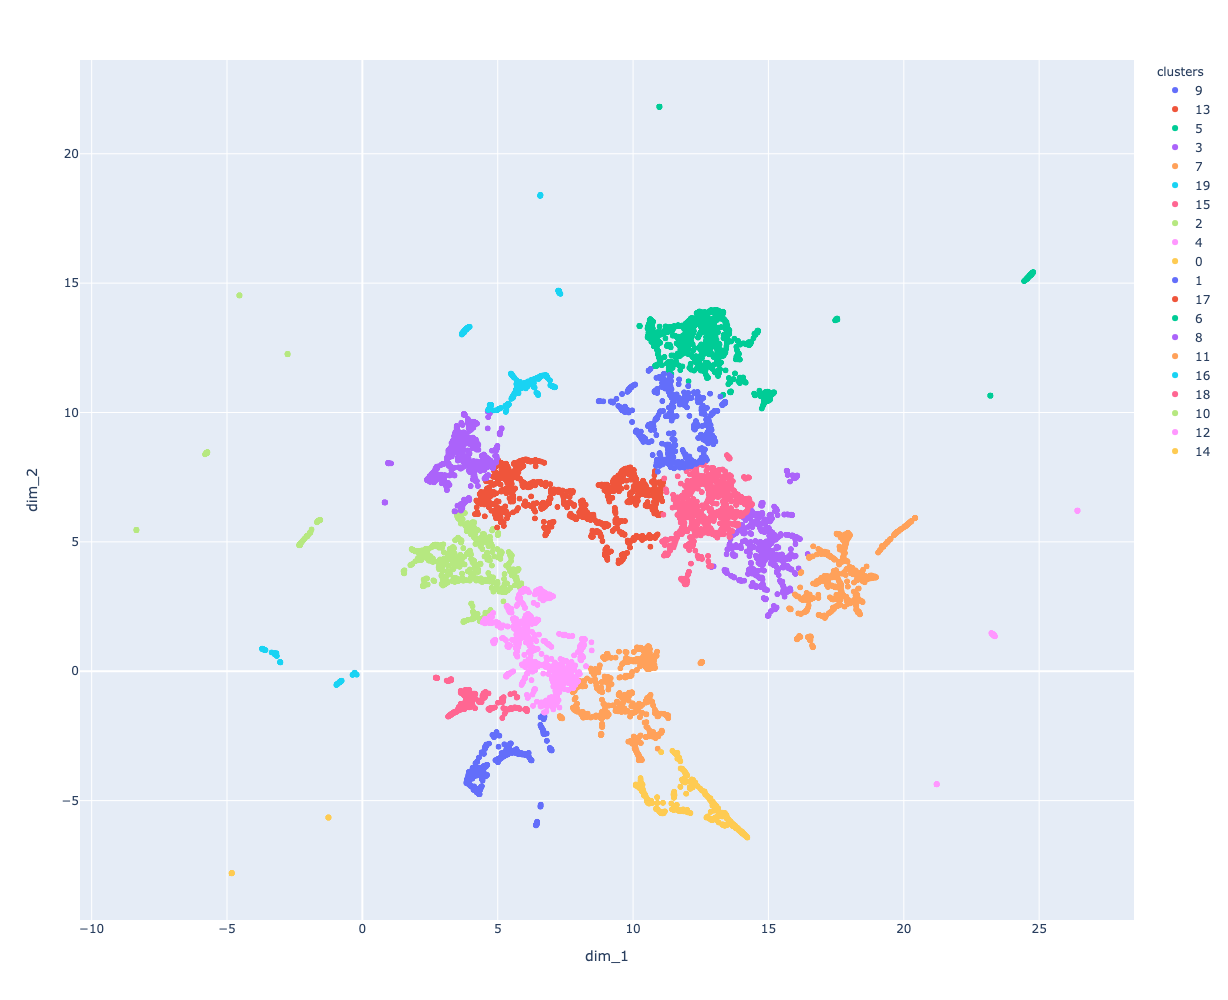

In [66]:
fig = make_bubble(embeddings_reduced, df, text_var= 'description', n_clusters=20)
fig.show()

#### Create Nested Embeddings & give them names

In [67]:
# Create Nested clusters.

df_emb = pd.DataFrame(embeddings_reduced)
df_emb['imdb'] = df['imdb']
h_clusters = hierarchical_clusters(df_emb)

In [68]:
# merge with terms extracted previously
df_enrich = pd.merge(df, df_indexed_full, left_on = text_var, right_on = 'docs')
df_enrich = df_enrich[['imdb', 'main form']].copy()

In [76]:
# Merge clusters and original dataset
h_clusters_label = pd.merge(h_clusters, df_enrich, on = 'imdb')
h_clusters_label = h_clusters_label.rename(columns = {'main form':'lemma'})
h_clusters_names = hierarchical_clusters_label(h_clusters_label)

#### Make Treemap Diagram

In [40]:
fig = topics_treemap(nested_topics = h_clusters_names)
plotly.offline.plot(
        fig, auto_open=True, filename="saved_graph/treemap.html"
    )

'saved_graph/treemap.html'

#### Make Sankey Diagram

In [41]:
fig = make_sankey(h_clusters_names, field = 'imdb Movies', index_var = 'imdb')
plotly.offline.plot(
        fig, auto_open=True, filename="saved_graph/sankey.html"
    )

'saved_graph/sankey.html'

In [ ]:
fig = topics_sunburst(h_clusters_names, field = 'imdb Movies', index_var = 'imdb')
plotly.offline.plot(
        fig, auto_open=True, filename="saved_graph/sunburst.html"
    )